# Entanglement in Time
## Genuine entanglement detection with Bell circuit

Piotr.Zawadzki@polsl.pl

License: Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
License details: [https://creativecommons.org/licenses/by-nc/4.0/](https://creativecommons.org/licenses/by-nc/4.0/)

This series of notebooks demonstrate the correlations and existence of genuine entanglement in entanglement swapping and entanglement in time generation processes. The series is composed from six notebooks:

- ES0a -- entanglement swapping, correlation of measurements in computational basis,
- ES0b -- entanglement swapping, correlation of measurements in dual basis,
- ES0c -- entanglement swapping, detection of genuine entanglement with Bell measurement circuit,
- ET0a -- entanglement in time generation, correlation of measurements in computational basis,
- ET0b -- entanglement in time generation, correlation of measurements in dual basis,
- ET0c -- entanglement in time generation, detection of genuine entanglement with Bell measurement circuit.

Every notebook is composed from three parts: circuit definit, classical simulation, execution on physical hardware.
They can be run as is in IBM Quantum Lab.

### Utility functions

In [3]:
# function extracts from "memory" only measurements for which classical registers B and C are equal to parameters bb and cc
# in other words we make postselection on a type of an EPR pair measured by Victor
# returns observations in registers A and D as strings
def postselect_on_BC( memory, bb, cc ):
    Areg='' ;  Dreg=''
    for cbits in memory: # Every shot is represented in "memory" as a string
        a = cbits[-1] ; b = cbits[-3] ; c = cbits[-5] ; d = cbits[-7] # register "a" is represented as the rightmost one
        if b == bb and c == cc:
            Areg += a ; Dreg += d
    return Areg, Dreg

# function verifies whether the charcters at the given index in two string are equal to values set by parameters aa and dd
# these strings are extracted from experiment memory and represent measurement outcomes observed on a given register
def agreement( Areg, Dreg, aa, dd ):
    if len(Areg) != len(Dreg):
        raise ValueError("The input strings must have the same length.")
    agreed = 0 
    for k in range(len(Areg)):
        if Areg[k]==aa and Dreg[k]==dd:
            agreed+=1
    return agreed*100.0/len(Areg)

### Qiskit modules

In [4]:
# Modules 
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider,least_busy
from qiskit.tools.monitor import job_monitor
# Registers
qreg_qA = QuantumRegister(1, 'qA')
qreg_qB = QuantumRegister(1, 'qB')
qreg_qC = QuantumRegister(1, 'qC')
qreg_qD = QuantumRegister(1, 'qD')
creg_a = ClassicalRegister(1, 'a')
creg_b = ClassicalRegister(1, 'b')
creg_c = ClassicalRegister(1, 'c')
creg_d = ClassicalRegister(1, 'd')

provider=IBMProvider()
my_accounts = provider.saved_accounts()
if not my_accounts:
    print("Please replace 'your_IBM_token' and run again this cell TWICE!")
    provider.save_account(token = "your_IBM_token")
else:
    print( "This notebook can use the following accounts:", my_accounts)
    print("Your active account is:", provider.active_account())

This notebook can use the following accounts: {'default-ibm-quantum': {'channel': 'ibm_quantum', 'token': '3916e4c5264ba03c0b45d1922e3a94788282bc86be988380a64fa97d9afd7fa68d97f1b9e1ce83e21d2443372ce4acfeb3d6a25cdb33c23849b546337aa70f90', 'url': 'https://auth.quantum-computing.ibm.com/api', 'verify': True}}
Your active account is: {'channel': 'ibm_quantum', 'token': '3916e4c5264ba03c0b45d1922e3a94788282bc86be988380a64fa97d9afd7fa68d97f1b9e1ce83e21d2443372ce4acfeb3d6a25cdb33c23849b546337aa70f90', 'url': 'https://auth.quantum-computing.ibm.com/api', 'verify': True, 'instance': 'ibm-q/open/main'}


### Quantum circuit

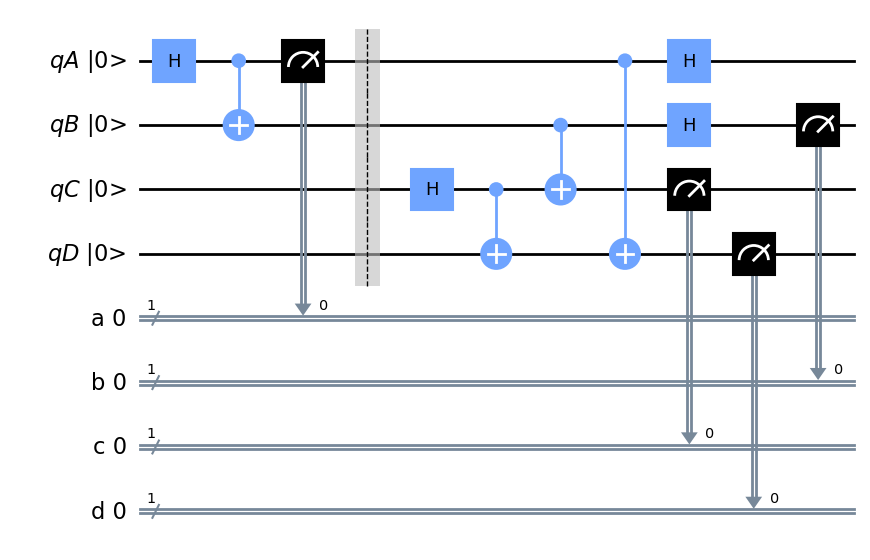

In [6]:
circ = QuantumCircuit(qreg_qA, qreg_qB, qreg_qC, qreg_qD, creg_a, creg_b, creg_c, creg_d)
circ.h(qreg_qA[0])
circ.cx(qreg_qA[0], qreg_qB[0])
circ.measure(qreg_qA[0], creg_a[0])
circ.barrier(qreg_qA[0], qreg_qB[0], qreg_qC[0], qreg_qD[0])
circ.h(qreg_qC[0])
circ.cx(qreg_qC[0], qreg_qD[0])
circ.cx(qreg_qB[0], qreg_qC[0])
circ.h(qreg_qB[0])
circ.measure(qreg_qB[0], creg_b[0])
circ.measure(qreg_qC[0], creg_c[0])
# circ.barrier(qreg_qA[0], qreg_qB[0], qreg_qC[0], qreg_qD[0])
circ.cx(qreg_qA[0], qreg_qD[0])
circ.h(qreg_qA[0])
circ.measure(qreg_qD[0], creg_d[0])
circ.draw('mpl',initial_state=True)

### Classical simulation

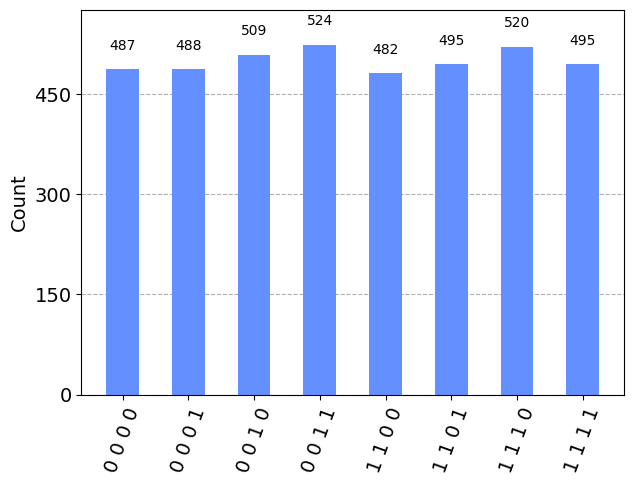

In [4]:
simulator = Aer.get_backend('qasm_simulator')
res_c = execute(circ, backend=simulator, shots=4000, memory=True).result()
counts_c = res_c.get_counts()
mem_c = res_c.get_memory()
plot_histogram( counts_c )

Postelection on $\lvert \beta_{0,0} \rangle_\mathrm{B,C}$ reults in $\lvert \beta_{0,0} \rangle_\mathrm{A,D}$. Bell measurement should always return 0,0.

In [5]:
Areg, Dreg = postselect_on_BC( mem_c, '0', '0' )
agreed_c = agreement( Areg, Dreg, '0', '0' )
print("Agreement ", agreed_c, "%" )

Agreement  49.94871794871795 %


### Execution on a quantum computer

In [6]:
devices=provider.backends(simulator=False, operational=True)
print(devices)
backend = least_busy( devices )
print(backend.name)
qcomp = provider.get_backend(backend.name)
tag = "Genuine entanglement detection for entanglement in time."
job = execute(circ, backend=qcomp, job_tags=[tag], memory=True)
job_session_id = job.job_id() 
print(tag + ". Job ID: ", job_session_id )
job_monitor( job )

[<IBMBackend('ibm_nairobi')>, <IBMBackend('ibmq_quito')>, <IBMBackend('ibmq_lima')>, <IBMBackend('ibm_lagos')>, <IBMBackend('ibm_perth')>, <IBMBackend('ibmq_jakarta')>, <IBMBackend('ibmq_belem')>, <IBMBackend('ibmq_manila')>]
ibmq_manila
Genuine entanglement detection for entanglement swapping.. Job ID:  cikq8i4t4v6egauqr9m0
Job Status: job has successfully run


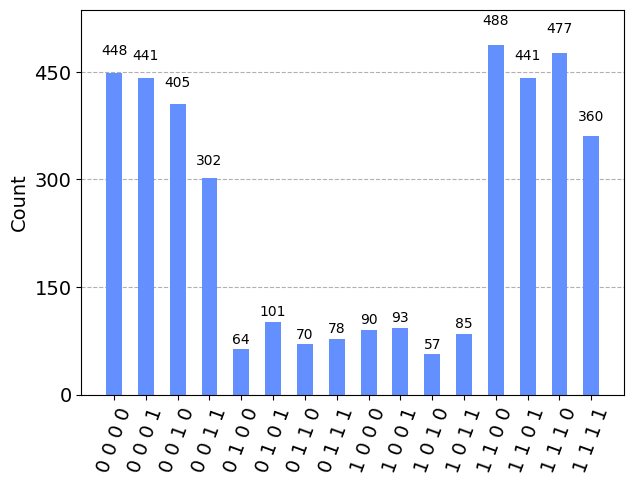

In [7]:
# uncomment if the notebook has been restarted since submitting job, replace job_session_id with a value printed above
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit.visualization import plot_histogram
# service = QiskitRuntimeService()
# job = service.job( "cikpmhsxxxxxxxxx" )
res_q = job.result()
counts_q = res_q.get_counts()
mem_q = res_q.get_memory()
plot_histogram( counts_q )

In [8]:
Areg, Dreg = postselect_on_BC( mem_q, '0', '0' )
agreed_q = agreement( Areg, Dreg, '0', '0' )
print("Agreement ", agreed_q, "% vs classic ", agreed_c, "%" )

Agreement  41.791044776119406 % vs classic  49.94871794871795 %


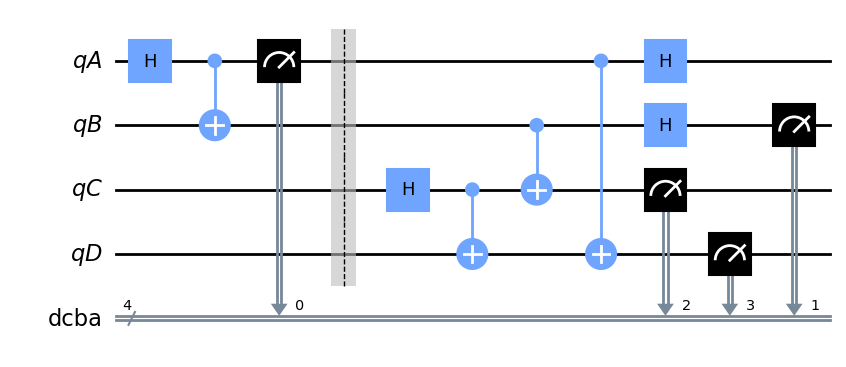

In [9]:
qreg_qA = QuantumRegister(1, 'qA')
qreg_qB = QuantumRegister(1, 'qB')
qreg_qC = QuantumRegister(1, 'qC')
qreg_qD = QuantumRegister(1, 'qD')
creg_dcba = ClassicalRegister(4, 'dcba')
qc = QuantumCircuit(qreg_qA, qreg_qB, qreg_qC, qreg_qD, creg_dcba)
qc.h(qreg_qA[0])
qc.cx(qreg_qA[0], qreg_qB[0])
qc.measure(qreg_qA[0], creg_dcba[0])
qc.barrier(qreg_qA[0], qreg_qB[0], qreg_qC[0], qreg_qD[0])
qc.h(qreg_qC[0])
qc.cx(qreg_qC[0], qreg_qD[0])
qc.cx(qreg_qB[0], qreg_qC[0])
qc.h(qreg_qB[0])
qc.measure(qreg_qB[0], creg_dcba[1])
qc.measure(qreg_qC[0], creg_dcba[2])
# circ.barrier(qreg_qA[0], qreg_qB[0], qreg_qC[0], qreg_qD[0])
qc.cx(qreg_qA[0], qreg_qD[0])
qc.h(qreg_qA[0])
qc.measure(qreg_qD[0], creg_dcba[3])
qc.draw('mpl')

In [11]:
latex_code = qc.draw(output='latex_source')
print(latex_code)
filename = 'genuine-entanglement-in-time.tex'
with open(filename, 'w') as file:
    file.write(latex_code)
print(f"Circuit saved to {filename}")

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{qA} :  } & \lstick{{qA} :  } & \gate{\mathrm{H}} & \ctrl{1} & \meter \barrier[0em]{3} & \qw & \qw & \qw & \qw & \ctrl{3} & \gate{\mathrm{H}} & \qw & \qw & \qw & \qw\\
	 	\nghost{{qB} :  } & \lstick{{qB} :  } & \qw & \targ & \qw & \qw & \qw & \qw & \ctrl{1} & \qw & \gate{\mathrm{H}} & \qw & \meter & \qw & \qw\\
	 	\nghost{{qC} :  } & \lstick{{qC} :  } & \qw & \qw & \qw & \qw & \gate{\mathrm{H}} & \ctrl{1} & \targ & \qw & \meter & \qw & \qw & \qw & \qw\\
	 	\nghost{{qD} :  } & \lstick{{qD} :  } & \qw & \qw & \qw & \qw & \qw & \targ & \qw & \targ & \qw & \meter & \qw & \qw & \qw\\
	 	\nghost{\mathrm{{dcba} :  }} & \lstick{\mathrm{{dcba} :  }} & \lstick{/_{_{4}}} \cw & \cw & \dstick{_{_{\hspace{0.0em}0}}} \cw \ar @{<=} [-4,0] & \cw & \cw & \cw & \cw & \cw & \dstick{_{_{\hspace{0.0em}2}}} \cw \ar @{<=} [-2,0] & \ds